## Note
This notebook serves as a mini tutorial on what you need to fine tune the model on a custom dataset in the simplest way. 

The main things that need to be done to do so is to create a dataset class following the implementation of the Coralscapes class and to add the model checkpoint in the arguments of the training script or in the configuration file.

In [1]:
# Load the autoreload extension
%load_ext autoreload

# Set autoreload mode
%autoreload 2

# Setup

In [2]:
import torch 

import albumentations as A

from torch.utils.data import DataLoader
from coralscapesScripts.datasets.dataset import Coralscapes
from coralscapesScripts.datasets.preprocess import get_preprocessor
from coralscapesScripts.datasets.utils import calculate_weights

from coralscapesScripts.segmentation.model import Benchmark_Run
from coralscapesScripts.segmentation.benchmarking import launch_benchmark

from coralscapesScripts.visualization import show_samples

from coralscapesScripts.logger import Logger, save_benchmark_run
from coralscapesScripts.io import setup_config, get_parser, update_config_with_args
import copy

/home/viktor/micromamba/envs/coralscapes/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.4' (you have '2.0.2'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [4]:
device_count = torch.cuda.device_count()
for i in range(device_count):
    print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
    
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

CUDA Device 0: NVIDIA GeForce RTX 2080 Ti
CUDA Device 1: NVIDIA GeForce GTX 980 Ti


device(type='cuda')

## Config

- Currently the Benchmark_Run takes the cfg and pops out the different parts (meaning the cfg file is **changed** after the object initialization). 
- If you want to look at the cfg after that, use the cfg_logger copy which will contain the original configuration. 
- Keep in mind due to this that if you try to "recreate" the Benchmark_Run object without rerunning the configuration it will most likely result in an error, so better to start over (or at least just rerun the config part of the script). 

In [5]:
cfg = setup_config(config_path='../configs/segformer-mit-b2_lora.yaml', config_base_path='../configs/base.yaml')

## Args

### Note
- As in the command line, here the arguments take presedence over the config file, so here you can overwrite/test out some parameters without directly changing the cfg. 
- Keep in mind not all parameters of the config can be changed through cmd (you can see which ones in the get_parser and update_config_with_args function). 

In [6]:
args_input = "--run-name=fine_tune_notebook --batch-size=2 --batch-size-eval=2 --epochs=100"
args_input = args_input.split(" ")

parser = get_parser()
args = parser.parse_args(args_input)

cfg = update_config_with_args(cfg, args)
cfg_logger = copy.deepcopy(cfg)

# Data

### Note
Make a new dataset class using the Coralscapes class in coralscapesScripts.datasets.dataset as an example. Importantly, it needs to contain the following as arguments 
- transform (albumentations)
- transform_target 
- N_classes
- id2label  

In [7]:
transforms = {}
for split in cfg.augmentation:
    transforms[split] = A.Compose(
        [
            getattr(A, transform_name)(**transform_params) for transform_name, transform_params
                                                                 in cfg.augmentation[split].items()
        ]
    )

In [8]:
train_dataset = Coralscapes(root = cfg.data.root, split = 'train', transform = transforms["train"])

transform_target = cfg.training.eval.transform_target if cfg.training.eval is not None and cfg.training.eval.transform_target is not None else True

val_dataset = Coralscapes(root = cfg.data.root, split = 'val', transform = transforms["val"], transform_target=transform_target) 
test_dataset = Coralscapes(root = cfg.data.root, split = 'test', transform = transforms["test"], transform_target=transform_target)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=cfg.data.batch_size, shuffle=True, num_workers=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.data.batch_size_eval, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=cfg.data.batch_size_eval, shuffle=False, num_workers=2)

In [10]:
print(len(train_loader), len(val_loader), len(test_loader))

759 83 196


In [11]:
weight = calculate_weights(train_dataset).to(device) if(cfg.data.weight) else None

## Visualizations

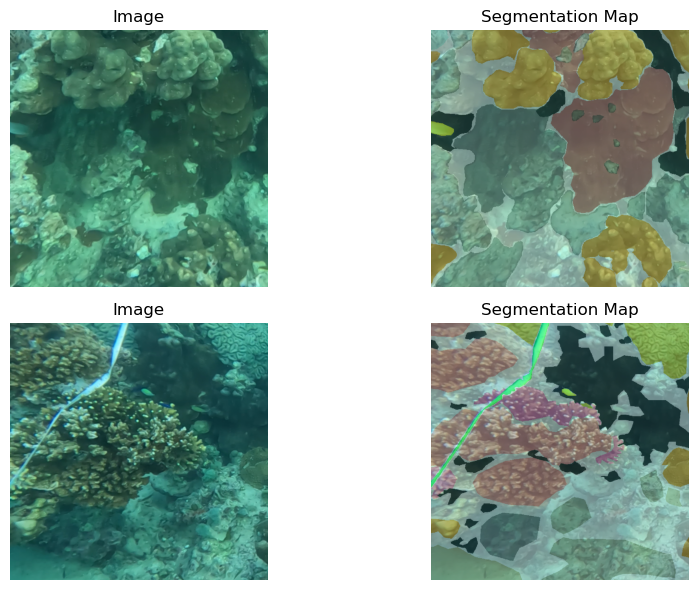

In [12]:
show_samples(train_dataset, n=2)

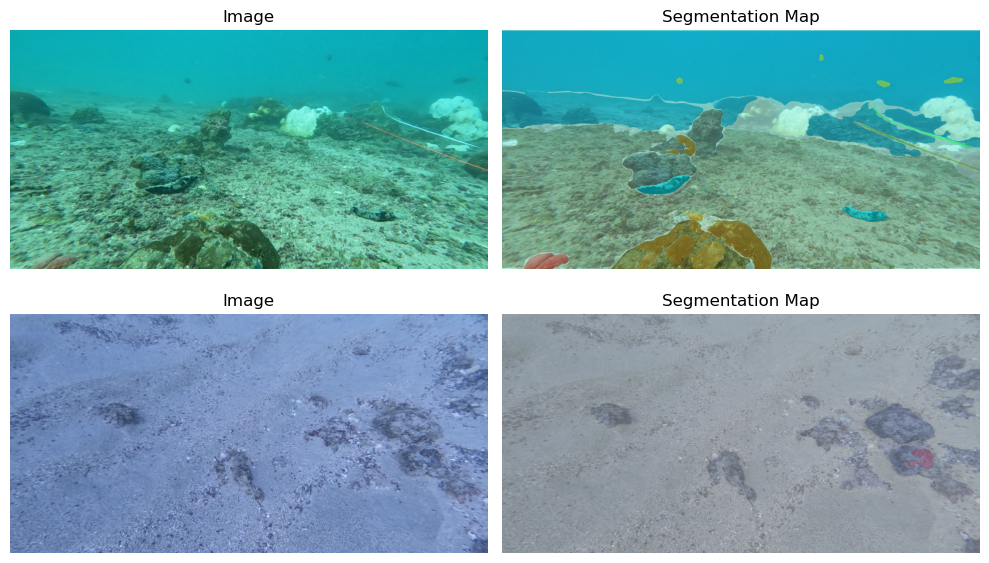

In [13]:
show_samples(val_dataset, n=2)

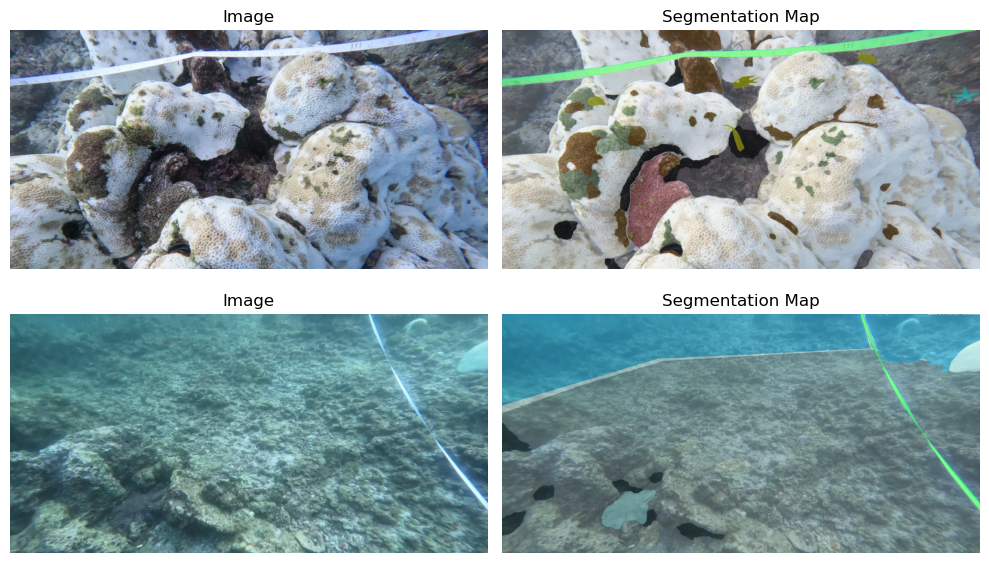

In [14]:
show_samples(test_dataset, n=2)

# Benchmarking

## Model

In [16]:
benchmark_run = Benchmark_Run(run_name = cfg.run_name, model_name = cfg.model.name, 
                                    N_classes = train_dataset.N_classes, device= device, 
                                    model_kwargs = cfg.model.kwargs,
                                    model_checkpoint = cfg.model.checkpoint,
                                    lora_kwargs = cfg.lora,
                                    training_hyperparameters = cfg.training)

/home/viktor/micromamba/envs/coralscapes/lib/python3.11/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'ignore_index', 'num_labels'
  return func(*args, **kwargs)
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weig

### Note
- If you want to use a LoRA approach, as long as you have it in the config (as in this case) with the correct parameters, you are good to go to the training script, no other changes need to be made.  
- If you want to freeze a specific layer, the easiest start is to just look at the model here and freeze the parameters you prefer.

In [ ]:
benchmark_run.model

## Logger

In [ ]:
logger = Logger(
    project = cfg.logger.wandb_project,
    benchmark_run = benchmark_run,
    log_epochs = cfg.logger.log_epochs,
    config = cfg_logger,
    checkpoint_dir = "./"
)


wandb: Currently logged in as: viktor-domazetoski to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


## Run

In [18]:
benchmark_run.print_trainable_parameters()

trainable params: 26687608 || all params: 26687608 || trainable%: 100.00


In [ ]:
benchmark_metrics = launch_benchmark(train_loader, val_loader, test_loader, benchmark_run, logger = logger)
save_benchmark_run(benchmark_run, benchmark_metrics)